In [1]:
!nvidia-smi

Wed Jan 10 19:17:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import datetime
import pathlib
import zipfile
import os



# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-01-10 20:08:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.207, 142.250.128.207, 172.253.114.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   267MB/s    in 0.6s    

2024-01-10 20:08:06 (267 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [3]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [4]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [23]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# MobileNetV2
mobilenetv2_url = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4"


In [6]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [7]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [8]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240110-191748
Epoch 1/5
24/24 [==============================] - 23s 583ms/step - loss: 2.0872 - accuracy: 0.3160 - val_loss: 1.2572 - val_accuracy: 0.5880
Epoch 2/5
24/24 [==============================] - 11s 457ms/step - loss: 0.9452 - accuracy: 0.7160 - val_loss: 0.8658 - val_accuracy: 0.7220
Epoch 3/5
24/24 [==============================] - 11s 454ms/step - loss: 0.6483 - accuracy: 0.8253 - val_loss: 0.7690 - val_accuracy: 0.7528
Epoch 4/5
24/24 [==============================] - 12s 496ms/step - loss: 0.4989 - accuracy: 0.8733 - val_loss: 0.7142 - val_accuracy: 0.7620
Epoch 5/5
24/24 [==============================] - 13s 547ms/step - loss: 0.4013 - accuracy: 0.9093 - val_loss: 0.6852 - val_accuracy: 0.7740


In [9]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

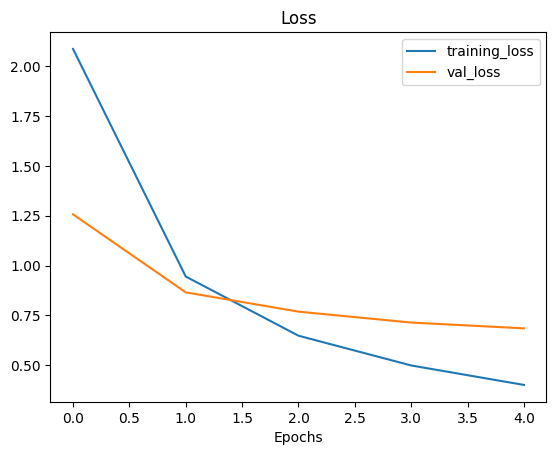

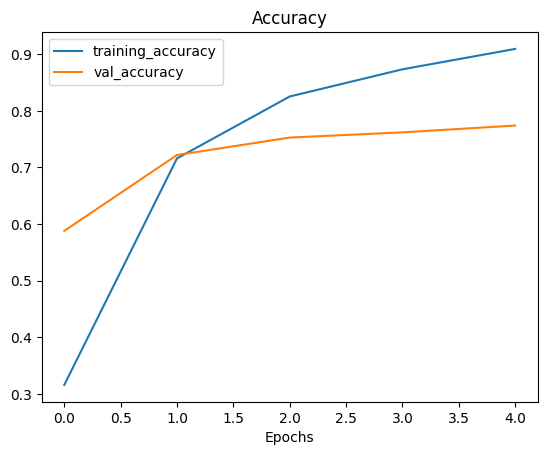

In [10]:
plot_loss_curves(resnet_history)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [19]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240110-193520
Epoch 1/5
24/24 [==============================] - 24s 576ms/step - loss: 1.8253 - accuracy: 0.4520 - val_loss: 1.2822 - val_accuracy: 0.7312
Epoch 2/5
24/24 [==============================] - 10s 424ms/step - loss: 1.0445 - accuracy: 0.7747 - val_loss: 0.8549 - val_accuracy: 0.8220
Epoch 3/5
24/24 [==============================] - 10s 415ms/step - loss: 0.7395 - accuracy: 0.8387 - val_loss: 0.6908 - val_accuracy: 0.8432
Epoch 4/5
24/24 [==============================] - 10s 431ms/step - loss: 0.5985 - accuracy: 0.8640 - val_loss: 0.6062 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 10s 425ms/step - loss: 0.5073 - accuracy: 0.8893 - val_loss: 0.5530 - val_accuracy: 0.8644


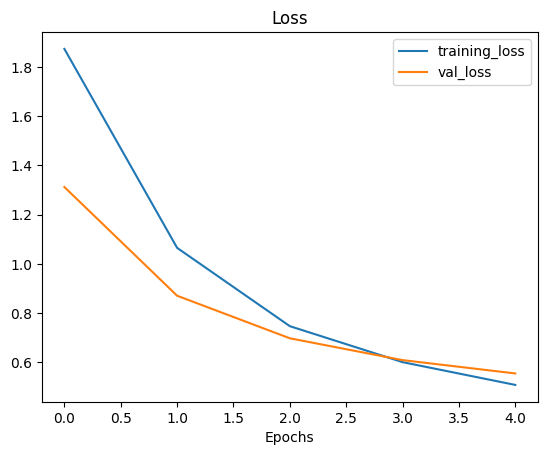

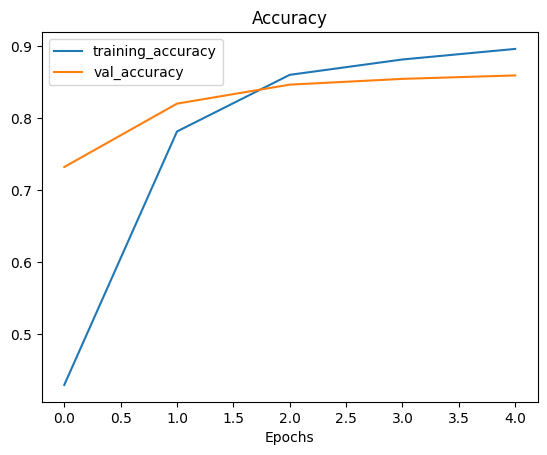

In [13]:
plot_loss_curves(efficientnet_history)

In [17]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [24]:
# Create model
mobilenetv2_model = create_model(model_url=mobilenetv2_url, # use mobilenetv2 URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
mobilenetv2_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
mobilenetv2_history = mobilenetv2_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="mobilenetv2")])

Saving TensorBoard log files to: tensorflow_hub/mobilenetv2/20240110-195546
Epoch 1/5
24/24 [==============================] - 18s 567ms/step - loss: 1.9307 - accuracy: 0.3520 - val_loss: 1.2847 - val_accuracy: 0.6352
Epoch 2/5
24/24 [==============================] - 9s 403ms/step - loss: 1.0280 - accuracy: 0.7120 - val_loss: 0.8759 - val_accuracy: 0.7472
Epoch 3/5
24/24 [==============================] - 9s 398ms/step - loss: 0.7139 - accuracy: 0.8120 - val_loss: 0.7376 - val_accuracy: 0.7868
Epoch 4/5
24/24 [==============================] - 10s 414ms/step - loss: 0.5659 - accuracy: 0.8573 - val_loss: 0.6866 - val_accuracy: 0.7900
Epoch 5/5
24/24 [==============================] - 10s 409ms/step - loss: 0.4747 - accuracy: 0.8720 - val_loss: 0.6465 - val_accuracy: 0.8064


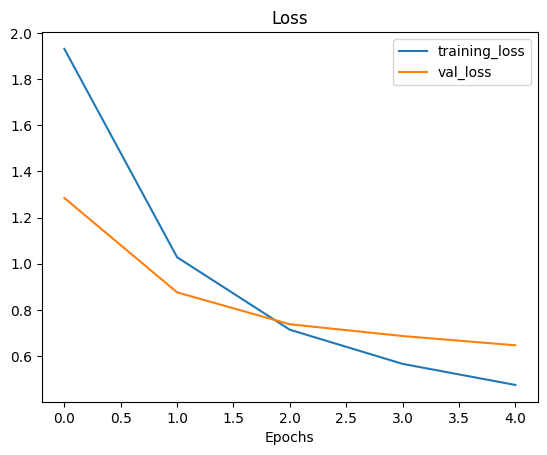

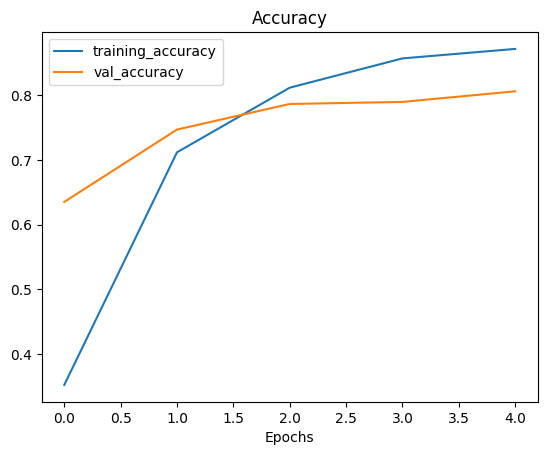

In [25]:
plot_loss_curves(mobilenetv2_history)

In [26]:
mobilenetv2_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              2257984   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2270794 (8.66 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [31]:
!wget https://github.com/kekonline/My-First-TF-CNN/raw/master/Data.zip

zip_ref = zipfile.ZipFile("Data.zip", "r")
zip_ref.extractall()
zip_ref.close()

data_dir = pathlib.Path("Data/Train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)


--2024-01-10 20:08:12--  https://github.com/kekonline/My-First-TF-CNN/raw/master/Data.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kekonline/My-First-TF-CNN/master/Data.zip [following]
--2024-01-10 20:08:12--  https://raw.githubusercontent.com/kekonline/My-First-TF-CNN/master/Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5350733 (5.1M) [application/zip]
Saving to: ‘Data.zip.2’

Data.zip.2          100%[===================>]   5.10M  --.-KB/s    in 0.07s   

2024-01-10 20:08:12 (69.4 MB/s) - ‘Data.zip.2’ saved [5350733/5350733]

['Book' 'Game']


In [35]:
# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "Data/Train/"
test_dir = "Data/Test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

Found 16 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [38]:
# Download the pretrained model and save it as a Keras layer
feature_extractor_layer = hub.KerasLayer(efficientnet_url,
                                         trainable=False, # freeze the underlying patterns
                                         name='feature_extraction_layer',
                                         input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

# Create our own model
efficientnet_gvb = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(1, activation='sigmoid', name='output_layer') # create our own output layer
    ])

# Compile EfficientNet model
efficientnet_gvb.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_gvb_history = efficientnet_gvb.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=valid_data,
                                              validation_steps=len(valid_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnet_gvb_history")])

Saving TensorBoard log files to: tensorflow_hub/efficientnet_gvb_history/20240110-202219
Epoch 1/5
1/1 [==============================] - 13s 13s/step - loss: 1.0348 - accuracy: 0.2500 - val_loss: 0.8307 - val_accuracy: 0.2500
Epoch 2/5
1/1 [==============================] - 1s 626ms/step - loss: 0.9640 - accuracy: 0.3125 - val_loss: 0.7867 - val_accuracy: 0.2500
Epoch 3/5
1/1 [==============================] - 1s 645ms/step - loss: 0.8962 - accuracy: 0.3125 - val_loss: 0.7447 - val_accuracy: 0.2500
Epoch 4/5
1/1 [==============================] - 1s 807ms/step - loss: 0.8317 - accuracy: 0.3750 - val_loss: 0.7048 - val_accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 1s 1s/step - loss: 0.7706 - accuracy: 0.5000 - val_loss: 0.6670 - val_accuracy: 0.7500


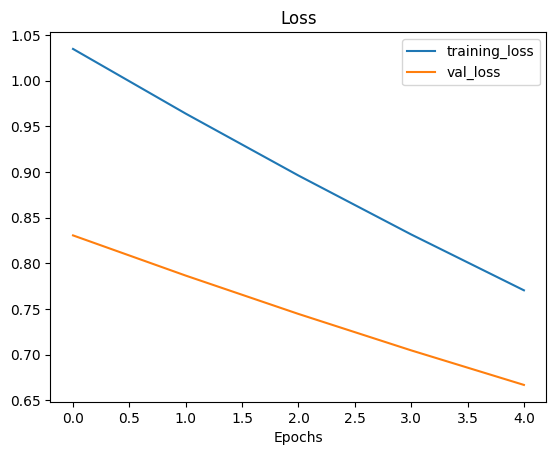

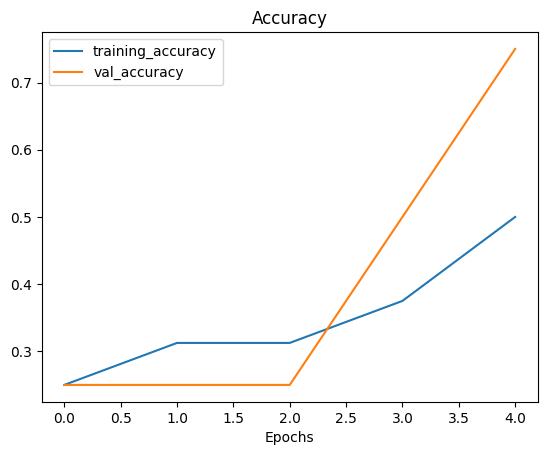

In [39]:
plot_loss_curves(efficientnet_gvb_history)